## Make the four panel $\sigma_{in}$, $\sigma_{out}$ plot

In [2]:
from analyze.analyze import AggregateCheckpoints
from models.models import model_setup_DER, model_setup_DE
from data.data import DataPreparation
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset
import pandas as pd
import seaborn as sns

In [3]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoints = AggregateCheckpoints()

This cell plots the mean and std for each $\sigma_{\rm al}$ value.

NO WERE NOT VARYING SIGMA
linear_homoskedastic simulation data generated,                 with noise injected type: predictive.
NO WERE NOT VARYING SIGMA
linear_homoskedastic simulation data generated,                 with noise injected type: predictive.
NO WERE NOT VARYING SIGMA
linear_homoskedastic simulation data generated,                 with noise injected type: predictive.


/var/folders/5m/wnsjjcln435g2yq5mmxf45k00000gz/T/ipykernel_20013/726368870.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  df[key] = torch.tensor(value)


NO WERE NOT VARYING SIGMA
linear_homoskedastic simulation data generated,                 with noise injected type: predictive.
loading this file ../DeepUQResources/checkpoints/DER_linear_homoskedastic_predictive_0D_noise_low_loss_DER_COEFF_0.01_epoch_99_sizedf_1000.pt
this is the mean u_al value 0.01428278
NO WERE NOT VARYING SIGMA
linear_homoskedastic simulation data generated,                 with noise injected type: predictive.
loading this file ../DeepUQResources/checkpoints/DER_linear_homoskedastic_predictive_0D_noise_medium_loss_DER_COEFF_0.01_epoch_99_sizedf_1000.pt
this is the mean u_al value 0.04475164
NO WERE NOT VARYING SIGMA
linear_homoskedastic simulation data generated,                 with noise injected type: predictive.
loading this file ../DeepUQResources/checkpoints/DER_linear_homoskedastic_predictive_0D_noise_high_loss_DER_COEFF_0.01_epoch_99_sizedf_1000.pt
this is the mean u_al value 0.09063464
YES WERE VARYING SIGMA
linear_homoskedastic simulation data generated

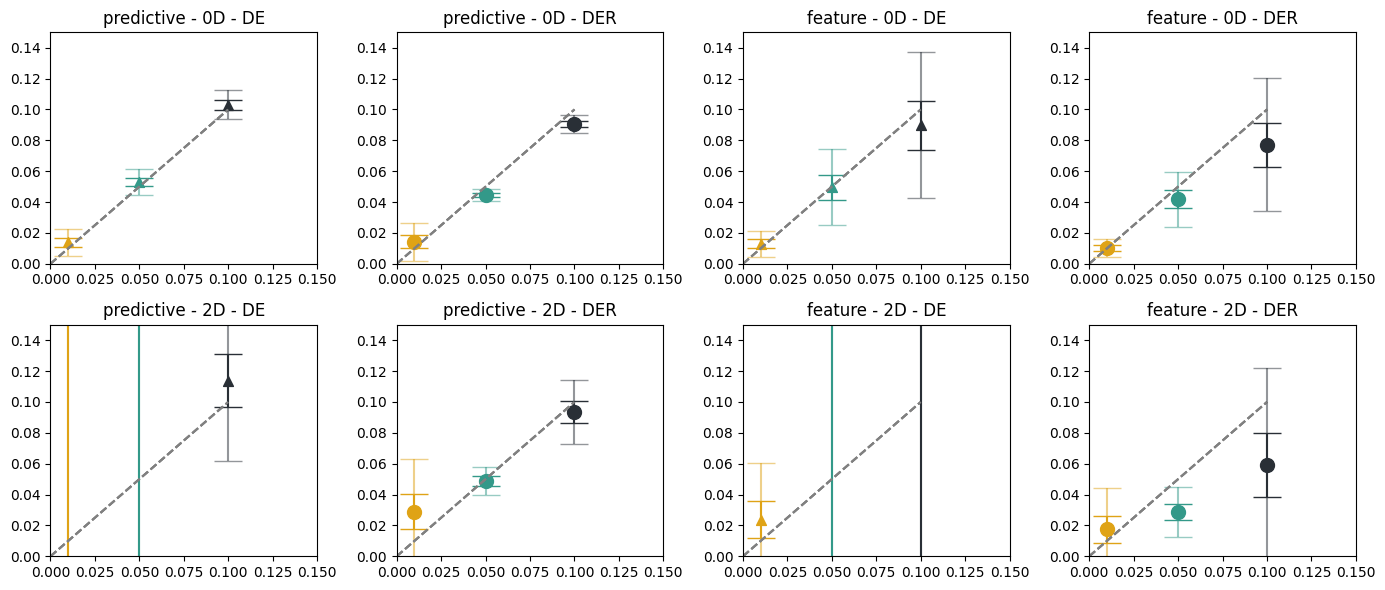

In [27]:
prescription = "linear_homoskedastic"
inject_type_list = ["predictive", "feature"]
data_dim_list = ["0D", "2D"]
model_type = ["DE", "DER"]
noise_list = ["low", "medium", "high"]
# these are the three colors for the three noise levels
color_list = ["#DFA316", "#339989", "#292F36"]
size_df_linear = 1000
size_df_image = 5000
epoch = 99
ensemble = True
n_models = 10

fig, axes = plt.subplots(2, 4, figsize=(14, 6))  
axes = axes.flatten()
index = 0

sigma_y_lookup = {'low': 0.01, 'medium': 0.05, 'high': 0.10}

# Iterate over the combinations of the two lists
for j, dim in enumerate(data_dim_list):
    for i, inject_type in enumerate(inject_type_list):
        
        # first go through the two different model types
        for m, model in enumerate(model_type):
            ax = axes[index]
            ax.set_title(f'{inject_type} - {dim} - {model}')
            index += 1
            for n, noise in enumerate(noise_list):
                
                # make the test set
                data = DataPreparation()
                
                if dim == "0D":
                    data.sample_params_from_prior(size_df_linear)
                    if inject_type == "feature":
                        data.simulate_data(
                            data.params,
                            noise,
                            "linear_homoskedastic",
                            inject_type=inject_type,
                            seed=41,
                            vary_sigma=True,
                        )
                    else:
                        sigma = DataPreparation.get_sigma(
                            noise, inject_type=inject_type, data_dimension=dim)
                        data.simulate_data(
                            data.params,
                            sigma,
                            "linear_homoskedastic",
                            inject_type=inject_type,
                            seed=41,
                        )
                    df_array = data.get_dict()
                    # Convert non-tensor entries to tensors
                    df = {}
                    for key, value in df_array.items():
                
                        if isinstance(value, TensorDataset):
                            # Keep tensors as they are
                            df[key] = value
                        else:
                            # Convert lists to tensors
                            df[key] = torch.tensor(value)
                    len_df = len(df["params"][:, 0].numpy())
                    len_x = np.shape(df["output"])[1]
                    ms_array = np.repeat(df["params"][:, 0].numpy(), len_x)
                    bs_array = np.repeat(df["params"][:, 1].numpy(), len_x)
                    xs_array = np.reshape(df["inputs"].numpy(), (len_df * len_x))
                    ys_array = np.reshape(df["output"].numpy(), (len_df * len_x))
                
                    inputs = np.array([xs_array, ms_array, bs_array]).T
                    model_inputs = inputs
                    model_outputs = ys_array
                elif dim == "2D":
                    sigma = DataPreparation.get_sigma(
                        noise, inject_type=inject_type, data_dimension=dim)
                    data.sample_params_from_prior(
                        size_df_image,
                        low=[0, 1, -1.5],
                        high=[0.01, 10, 1.5],
                        n_params=3,
                        seed=41)
                    model_inputs, model_outputs = data.simulate_data_2d(
                        size_df_image,
                        data.params,
                        image_size=32,
                        inject_type=inject_type,
                        sigma=sigma)
                x_test = model_inputs
                y_test = model_outputs
                
                # print(f"dim is {dim}, noise is {noise}, sigma is {sigma}, inject is {inject_type}")
                path = "../DeepUQResources/checkpoints/"
                if model == "DER":
                    setupmodel, lossFn = model_setup_DER(
                        model, DEVICE, n_hidden=64, data_type=dim)
                    loss = "DER"
                    COEFF = 0.01
                    file_name = (
                        str(path)
                        + f"{model}_{prescription}_{inject_type}_{dim}"
                        + f"_noise_{noise}_loss_{loss}_COEFF_{COEFF}_epoch_{epoch}"
                    )
                    if dim == "0D":
                        file_name += f"_sizedf_{size_df_linear}"
                    elif dim == "2D":
                        file_name += f"_sizedf_{size_df_image}"
                    file_name += ".pt"
                    try:
                        print('loading this file', file_name)
                        chk = torch.load(file_name, map_location=DEVICE)
                    except FileNotFoundError:
                        print("cannot find this model", file_name)
                        continue
                    # define the model at this epoch
                    setupmodel.load_state_dict(chk.get("model_state_dict"))
                    # checkpoint['model_state_dict'])
                    setupmodel.eval()

                    y_pred = setupmodel(
                        torch.Tensor(x_test
                            )
                        ).detach().numpy()
                    #print(f'model = {model}, inject = {inject_type}, dim = {dim}, noise = {noise}') 
                    #print('DER this is the mean true value', np.mean(x_test))
                    #print('this is the mean predicted value', np.mean(y_pred[:, 0]))
                    beta = y_pred[:, 3]
                    nu = y_pred[:, 1]
                    alpha = y_pred[:, 2]
                    u_al = np.sqrt(
                        abs(
                        beta
                        * (1 + nu)
                        / (alpha * nu)
                        )
                    )
                    print('this is the mean u_al value', np.mean(u_al))
                    if np.isnan(np.mean(u_al)):
                        print('u_al', u_al[-1])
                        print('alpha', alpha[-1])
                        print('nu', nu[-1])
                        print('predicted values', y_pred[-1, 0])
                        print('true values', y_test[-1])
                        plt.clf()
                        plt.imshow(x_test[-1])
                        plt.colorbar()
                        plt.show()
                        STOP
                    # now standardize the output uncertainty
                    # _, u_al_denormed = denormalize(x_test, u_al, chk.get("norm_params"))
                    ax.errorbar(
                            sigma_y_lookup[noise],
                            np.mean(u_al),
                            yerr = np.std(u_al),
                            color=color_list[n],
                            capsize=10
                        )
                    ax.errorbar(
                            sigma_y_lookup[noise],
                            np.mean(u_al),
                            yerr = 3 * np.std(u_al),
                            color=color_list[n],
                            capsize=10,
                            alpha=0.5
                        )
                    ax.scatter(
                            sigma_y_lookup[noise],
                            np.mean(u_al),
                            color=color_list[n],
                            label=f"Noise level {noise}",
                            s=100
                        )
                    ax.plot([0,0.1], [0,0.1], color='grey', ls='--')  
                elif model == "DE":
                    loss = "bnll_loss"
                    setupmodel, lossFn = model_setup_DE(
                        loss, DEVICE, n_hidden=64, data_type=dim)
                    BETA = 0.5
                    u_al_list = []
                    for m in range(n_models):
                        file_name = (
                            str(path) +
                            f"{model}_{prescription}_{inject_type}_{dim}"
                            f"_noise_{noise}_beta_{BETA}_nmodel_{m}_epoch_{epoch}"
                        )
                        if dim == "0D":
                            file_name += f"_sizedf_{size_df_linear}"
                        elif dim == "2D":
                            file_name += f"_sizedf_{size_df_image}"
                        file_name += ".pt"
                        try:
                            chk = torch.load(file_name, map_location=DEVICE)
                        except FileNotFoundError:
                            print("cannot find this model", file_name)
                            continue
                        # define the model at this epoch
                        setupmodel.load_state_dict(chk.get("model_state_dict"))
                        # checkpoint['model_state_dict'])
                        setupmodel.eval()
                        y_pred = setupmodel(
                            torch.Tensor(x_test
                                )
                            ).detach().numpy()
                        #print(f'prediction for ensemble {m}') # {y_pred}')
                        #print(f'model = {model}, inject = {inject_type}, dim = {dim}, noise = {noise}') 
                        #print('DE this is the mean true value', np.mean(x_test))
                        #print('this is the mean predicted value', np.mean(y_pred[:, 0]))
                        u_al = np.sqrt(y_pred[:, 1])
                        u_al_list.append(u_al)
                        #print('this is the mean y_pred[:, 1] so variance', np.mean(y_pred[:, 1]))
                        #print('this is the mean u_al value', np.mean(u_al))

                        '''
                        if m == 0:
                            ax.errorbar(
                                sigma_y_lookup[noise],
                                np.mean(u_al),
                                yerr = np.std(u_al),
                                color=color_list[n],
                                capsize=10
                            )
                            ax.scatter(
                                    sigma_y_lookup[noise],
                                    np.mean(u_al),
                                    color=color_list[n],
                                    label=f"MVE",
                                    s=50,
                                    marker="^"
                                )
                        '''
                        '''
                        else:
                            ax.scatter(
                                    sigma_y_lookup[noise],
                                    np.mean(u_al),
                                    color=color_list[n],
                                    s=50,
                                    marker="^"
                                )
                        '''
                    ax.errorbar(sigma_y_lookup[noise],
                                np.mean(u_al_list),
                                yerr=np.std(u_al_list),
                                color=color_list[n],
                                #alpha=0.5,
                                capsize=10                                
                                )
                    ax.errorbar(sigma_y_lookup[noise],
                                np.mean(u_al_list),
                                yerr=3*np.std(u_al_list),
                                color=color_list[n],
                                alpha=0.5,
                                capsize=10                                
                                )
                    ax.scatter(sigma_y_lookup[noise],
                                np.mean(u_al_list),
                                color=color_list[n],
                                #alpha=0.5,
                                label=f"Noise level {noise}",
                                s=50,
                                marker="^"
                              )
                    ax.plot([0,0.1], [0,0.1], color='grey', ls='--')
                    
                
                if index == 0:
                    ax.legend()
                ax.set_xlim([0,0.15])
                ax.set_ylim([0,0.15])
plt.tight_layout()
#plt.show()
if ensemble:
    plt.savefig(f'../../../Desktop/sigma_in_sigma_out_ensemble_{n_models}.png', dpi=1000)
else:
    plt.savefig(f'../../../Desktop/sigma_in_sigma_out.png', dpi=1000)
print('made the plot')

## But let's make the distributions into violin plots instead

NO WERE NOT VARYING SIGMA
linear_homoskedastic simulation data generated,                 with noise injected type: predictive.
loading this file ../DeepUQResources/checkpoints/DE_linear_homoskedastic_predictive_0D_noise_low_beta_0.5_nmodel_0_epoch_99_sizedf_1000.pt
using this model  0
loading this file ../DeepUQResources/checkpoints/DE_linear_homoskedastic_predictive_0D_noise_low_beta_0.5_nmodel_1_epoch_99_sizedf_1000.pt
using this model  1
loading this file ../DeepUQResources/checkpoints/DE_linear_homoskedastic_predictive_0D_noise_low_beta_0.5_nmodel_2_epoch_99_sizedf_1000.pt
using this model  2
loading this file ../DeepUQResources/checkpoints/DE_linear_homoskedastic_predictive_0D_noise_low_beta_0.5_nmodel_3_epoch_99_sizedf_1000.pt
using this model  3
loading this file ../DeepUQResources/checkpoints/DE_linear_homoskedastic_predictive_0D_noise_low_beta_0.5_nmodel_4_epoch_99_sizedf_1000.pt
using this model  4
loading this file ../DeepUQResources/checkpoints/DE_linear_homoskedastic_pred

/var/folders/5m/wnsjjcln435g2yq5mmxf45k00000gz/T/ipykernel_43129/2630442683.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  df = {key: torch.tensor(value) if not isinstance(value, TensorDataset) else value for key, value in df_array.items()}


using this model  2
loading this file ../DeepUQResources/checkpoints/DE_linear_homoskedastic_predictive_0D_noise_high_beta_0.5_nmodel_3_epoch_99_sizedf_1000.pt
using this model  3
loading this file ../DeepUQResources/checkpoints/DE_linear_homoskedastic_predictive_0D_noise_high_beta_0.5_nmodel_4_epoch_99_sizedf_1000.pt
using this model  4
loading this file ../DeepUQResources/checkpoints/DE_linear_homoskedastic_predictive_0D_noise_high_beta_0.5_nmodel_5_epoch_99_sizedf_1000.pt
cannot find this model ../DeepUQResources/checkpoints/DE_linear_homoskedastic_predictive_0D_noise_high_beta_0.5_nmodel_5_epoch_99_sizedf_1000.pt
loading this file ../DeepUQResources/checkpoints/DE_linear_homoskedastic_predictive_0D_noise_high_beta_0.5_nmodel_6_epoch_99_sizedf_1000.pt
cannot find this model ../DeepUQResources/checkpoints/DE_linear_homoskedastic_predictive_0D_noise_high_beta_0.5_nmodel_6_epoch_99_sizedf_1000.pt
loading this file ../DeepUQResources/checkpoints/DE_linear_homoskedastic_predictive_0D_noi

/var/folders/5m/wnsjjcln435g2yq5mmxf45k00000gz/T/ipykernel_43129/2630442683.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  df = {key: torch.tensor(value) if not isinstance(value, TensorDataset) else value for key, value in df_array.items()}
/var/folders/5m/wnsjjcln435g2yq5mmxf45k00000gz/T/ipykernel_43129/2630442683.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  df = {key: torch.tensor(value) if not isinstance(value, TensorDataset) else value for key, value in df_array.items()}


using this model  4
loading this file ../DeepUQResources/checkpoints/DE_linear_homoskedastic_feature_0D_noise_low_beta_0.5_nmodel_5_epoch_99_sizedf_1000.pt
cannot find this model ../DeepUQResources/checkpoints/DE_linear_homoskedastic_feature_0D_noise_low_beta_0.5_nmodel_5_epoch_99_sizedf_1000.pt
loading this file ../DeepUQResources/checkpoints/DE_linear_homoskedastic_feature_0D_noise_low_beta_0.5_nmodel_6_epoch_99_sizedf_1000.pt
cannot find this model ../DeepUQResources/checkpoints/DE_linear_homoskedastic_feature_0D_noise_low_beta_0.5_nmodel_6_epoch_99_sizedf_1000.pt
loading this file ../DeepUQResources/checkpoints/DE_linear_homoskedastic_feature_0D_noise_low_beta_0.5_nmodel_7_epoch_99_sizedf_1000.pt
cannot find this model ../DeepUQResources/checkpoints/DE_linear_homoskedastic_feature_0D_noise_low_beta_0.5_nmodel_7_epoch_99_sizedf_1000.pt
loading this file ../DeepUQResources/checkpoints/DE_linear_homoskedastic_feature_0D_noise_low_beta_0.5_nmodel_8_epoch_99_sizedf_1000.pt
cannot find t

/var/folders/5m/wnsjjcln435g2yq5mmxf45k00000gz/T/ipykernel_43129/2630442683.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  df = {key: torch.tensor(value) if not isinstance(value, TensorDataset) else value for key, value in df_array.items()}


loading this file ../DeepUQResources/checkpoints/DE_linear_homoskedastic_predictive_2D_noise_low_beta_0.5_nmodel_0_epoch_99_sizedf_5000.pt
not using this model  0
loading this file ../DeepUQResources/checkpoints/DE_linear_homoskedastic_predictive_2D_noise_low_beta_0.5_nmodel_1_epoch_99_sizedf_5000.pt
not using this model  1
loading this file ../DeepUQResources/checkpoints/DE_linear_homoskedastic_predictive_2D_noise_low_beta_0.5_nmodel_2_epoch_99_sizedf_5000.pt
using this model  2
loading this file ../DeepUQResources/checkpoints/DE_linear_homoskedastic_predictive_2D_noise_low_beta_0.5_nmodel_3_epoch_99_sizedf_5000.pt
using this model  3
loading this file ../DeepUQResources/checkpoints/DE_linear_homoskedastic_predictive_2D_noise_low_beta_0.5_nmodel_4_epoch_99_sizedf_5000.pt
using this model  4
loading this file ../DeepUQResources/checkpoints/DE_linear_homoskedastic_predictive_2D_noise_low_beta_0.5_nmodel_5_epoch_99_sizedf_5000.pt
using this model  5
loading this file ../DeepUQResources/c

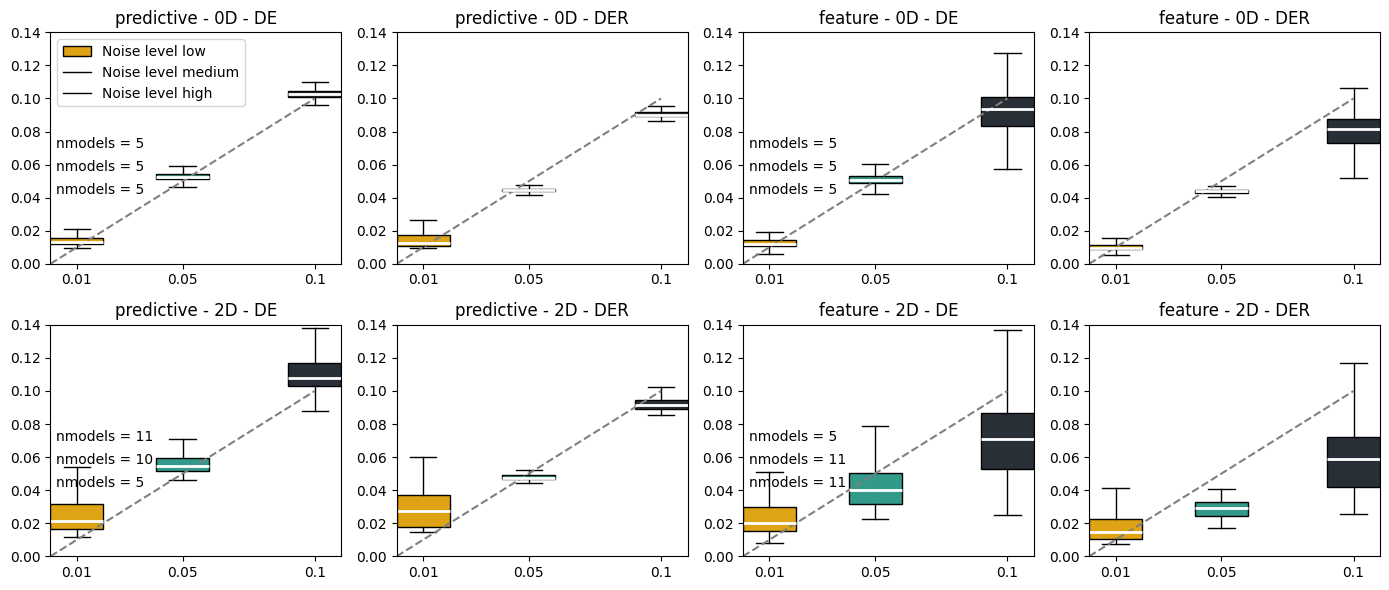

In [8]:
prescription = "linear_homoskedastic"
inject_type_list = ["predictive", "feature"]
data_dim_list = ["0D", "2D"]
model_type = ["DE", "DER"]
noise_list = ["low", "medium", "high"]
# these are the three colors for the three noise levels
color_list = ["#DFA316", "#339989", "#292F36"]
size_df_linear = 1000
size_df_image = 5000
epoch = 99
ensemble = True
n_models = 15

fig, axes = plt.subplots(2, 4, figsize=(14, 6))  
axes = axes.flatten()
index = 0

sigma_y_lookup = {'low': 0.01, 'medium': 0.05, 'high': 0.10}
# Iterate over the combinations of the two lists
for j, dim in enumerate(data_dim_list):
    for i, inject_type in enumerate(inject_type_list):
        
        for m, model in enumerate(model_type):
            ax = axes[index]
            ax.set_title(f'{inject_type} - {dim} - {model}')

            all_u_al_data = []  # Collect all data for the violin plot
            all_noise_labels = []
            all_sigma_y_labels = []
            for n, noise in enumerate(noise_list):
                chk = 0
                
                # make the test set
                data = DataPreparation()
                
                if dim == "0D":
                    data.sample_params_from_prior(size_df_linear)
                    if inject_type == "feature":
                        data.simulate_data(
                            data.params,
                            noise,
                            "linear_homoskedastic",
                            inject_type=inject_type,
                            seed=41,
                            vary_sigma=True,
                        )
                    else:
                        sigma = DataPreparation.get_sigma(
                            noise, inject_type=inject_type, data_dimension=dim)
                        data.simulate_data(
                            data.params,
                            sigma,
                            "linear_homoskedastic",
                            inject_type=inject_type,
                            seed=41,
                        )
                    df_array = data.get_dict()
                    df = {key: torch.tensor(value) if not isinstance(value, TensorDataset) else value for key, value in df_array.items()}
                    len_df = len(df["params"][:, 0].numpy())
                    len_x = np.shape(df["output"])[1]
                    ms_array = np.repeat(df["params"][:, 0].numpy(), len_x)
                    bs_array = np.repeat(df["params"][:, 1].numpy(), len_x)
                    xs_array = np.reshape(df["inputs"].numpy(), (len_df * len_x))
                    ys_array = np.reshape(df["output"].numpy(), (len_df * len_x))
                    inputs = np.array([xs_array, ms_array, bs_array]).T
                    model_inputs = inputs
                    model_outputs = ys_array
                elif dim == "2D":
                    sigma = DataPreparation.get_sigma(
                        noise, inject_type=inject_type, data_dimension=dim)
                    data.sample_params_from_prior(
                        size_df_image,
                        low=[0, 1, -1.5],
                        high=[0.01, 10, 1.5],
                        n_params=3,
                        seed=41)
                    model_inputs, model_outputs = data.simulate_data_2d(
                        size_df_image,
                        data.params,
                        image_size=32,
                        inject_type=inject_type,
                        sigma=sigma)
                x_test = model_inputs
                y_test = model_outputs
                
                path = "../DeepUQResources/checkpoints/"
                if model == "DER":
                    setupmodel, lossFn = model_setup_DER(
                        model, DEVICE, n_hidden=64, data_type=dim)
                    COEFF = 0.01
                    file_name = (
                        str(path)
                        + f"{model}_{prescription}_{inject_type}_{dim}"
                        + f"_noise_{noise}_loss_DER_COEFF_{COEFF}_epoch_{epoch}"
                    )
                    if dim == "0D":
                        file_name += f"_sizedf_{size_df_linear}"
                    elif dim == "2D":
                        file_name += f"_sizedf_{size_df_image}"
                    file_name += ".pt"
                    try:
                        print('loading this file', file_name)
                        chk = torch.load(file_name, map_location=DEVICE)
                    except FileNotFoundError:
                        print("cannot find this model", file_name)
                        continue
                    setupmodel.load_state_dict(chk.get("model_state_dict"))
                    setupmodel.eval()

                    y_pred = setupmodel(torch.Tensor(x_test)).detach().numpy()
                    beta = y_pred[:, 3]
                    nu = y_pred[:, 1]
                    alpha = y_pred[:, 2]
                    u_al = np.sqrt(abs(beta * (1 + nu) / (alpha * nu)))
                    
                elif model == "DE":
                    models_used = 0
                    loss = "bnll_loss"
                    setupmodel, lossFn = model_setup_DE(
                        loss, DEVICE, n_hidden=64, data_type=dim)
                    BETA = 0.5
                    u_al_list = []
                    for m in range(n_models):
                        if models_used > 10:
                            break
                        file_name = (
                            str(path) +
                            f"{model}_{prescription}_{inject_type}_{dim}"
                            f"_noise_{noise}_beta_{BETA}_nmodel_{m}_epoch_{epoch}"
                        )
                        if dim == "0D":
                            file_name += f"_sizedf_{size_df_linear}"
                        elif dim == "2D":
                            file_name += f"_sizedf_{size_df_image}"
                        file_name += ".pt"
                        try:
                            print('loading this file', file_name)
                            chk = torch.load(file_name, map_location=DEVICE)
                        except FileNotFoundError:
                            print("cannot find this model", file_name)
                            continue
                        setupmodel.load_state_dict(chk.get("model_state_dict"))
                        setupmodel.eval()
                        y_pred = setupmodel(torch.Tensor(x_test)).detach().numpy()
                        # for some reason if the model fails it predicts
                        # really large values for sigma
                        if np.mean(y_pred[:,1]) > 1:
                            # then we need to skip this model
                            print('not using this model ', m)
                        else:
                            models_used += 1
                            print('using this model ', m)
                        
                        u_al = np.sqrt(y_pred[:, 1])
                        u_al_list.append(u_al)
                    if noise == "low":
                        ax.annotate(f'nmodels = {models_used}', xy=(0.02,0.5), xycoords='axes fraction')
                    if noise == "medium":
                        ax.annotate(f'nmodels = {models_used}', xy=(0.02,0.4), xycoords='axes fraction')
                    if noise == "high":
                        ax.annotate(f'nmodels = {models_used}', xy=(0.02,0.3), xycoords='axes fraction')
                    u_al = np.concatenate(u_al_list)

                # Collect the data
                all_u_al_data.extend(u_al)
                all_sigma_y_labels.extend([sigma_y_lookup[noise]] * len(u_al))

            # Create a DataFrame for the box plot
            df_boxplot = pd.DataFrame({
                'u_al': all_u_al_data,
                'sigma_y': all_sigma_y_labels
            })
            df_boxplot = df_boxplot[df_boxplot['u_al'] <= 1]

            # Prepare the data for the box plot
            sigma_y_values = [0.01,0.05,0.1]
            data = [df_boxplot[df_boxplot['sigma_y'] == val]['u_al'] for val in sigma_y_values]

            # Plot the box plot with specific positions using Matplotlib's boxplot method
            bp = ax.boxplot(data, positions=sigma_y_values, widths=0.02, patch_artist=True, whis=1.5, showfliers=False)

            # Set colors for each box
            for patch, color in zip(bp['boxes'], color_list):
                patch.set_facecolor(color)

            # control the color of the median line
            # Set colors for median lines
            median_color = 'white'  # Change this to your desired color
            for median in bp['medians']:
                median.set_color(median_color)
                median.set_linewidth(2)

            '''
                # Collect the data
                all_u_al_data.extend(u_al)
                all_sigma_y_labels.extend([sigma_y_lookup[noise]] * len(u_al))
            
            # Create a DataFrame for the box plot
            df_boxplot = pd.DataFrame({
                'u_al': all_u_al_data,
                'sigma_y': all_sigma_y_labels
            })
            df_boxplot = df_boxplot[df_boxplot['u_al'] <= 1]
            
            # Plot the box plot
            sns.boxplot(x='sigma_y', y='u_al',
                        data=df_boxplot, ax=ax,
                        palette=color_list, width=0.2,
                        whis=1.5, showfliers=False,
                        positions=[0.01,0.05,0.1])

            #ax.plot([0, 3], [0, 0.15], color='grey', ls='--')
            #
            '''
            ax.plot([0,0.1], [0,0.1], color='grey', ls='--')

            if index == 0:
                ax.legend([f"Noise level {noise}" for noise in noise_list], loc='upper left')
            ax.set_xlim([0, 0.11])
            ax.set_ylim([0, 0.14])
            #ax.set_xlim([0, 0.15])
            #ax.set_ylim([0, 1])

            index += 1
            #plt.show()
            #STOP

plt.tight_layout()
if ensemble:
    plt.savefig(f'../../../Desktop/sigma_in_sigma_out_boxplot_ensemble_{n_models}.png', dpi=1000)
else:
    plt.savefig(f'../../../Desktop/sigma_in_sigma_out_boxplot.png', dpi=1000)
print('made the plot')